# Read in data

In [3]:
import pandas as pd
import pyplot_themes as themes
import sys 

def get_exposure(x):
    if "many_gpt" in x:
        return "high_exposure"
    elif "few_gpt" in x:
        return "low_exposure"
    else:
        return "control"

def get_transparency(x):
    if "unlabled" in x:
        return "unlabled"
    elif "labled" in x:
        return "labled"
    else:
        return 'control'
    
# Turn off value-on-slice warning
pd.options.mode.chained_assignment = None  # default='warn'


# Fix meta df
meta = pd.read_csv("condition_df.csv")
meta['index'] = meta.index 
meta_melted = meta.melt(id_vars=['index'], value_vars=['human_item', 'many_gpt_labled_item', 'few_gpt_labled_item', 'many_gpt_unlabled_item', 'few_gpt_unlabled_item'], var_name='condition', value_name='item')
meta_melted['item'] = meta_melted['item'].str.split('_')
meta_reshaped = meta_melted[['index', 'condition', 'item']]
meta_reshaped['item'] = meta_reshaped['item'].apply(lambda x: x[0])
meta_reshaped['condition'] = meta_reshaped['condition'].apply(lambda x: x.replace("_item", ""))


# Read in qualtrics df 
df = pd.read_csv("qualtrics2.csv")
df = df.dropna(axis=1, thresh=3)
df = df.iloc[2:, :]
df = df.melt(id_vars=['prolific_id', 'RecordedDate'],
             var_name='question_condition', value_name='response')
df[['loop_merge_no', 'condition']] = df['question_condition'].str.split('_', n=1, expand=True)
df.drop(columns=['question_condition'], inplace=True)
df = df[['prolific_id', 'RecordedDate', 'condition', 'loop_merge_no', 'response']]
df2 = df[df["condition"].notnull()]
df2['loop_merge_no'] = [int(x)-2 for x in df2['loop_merge_no'].tolist()]
# Merge meta df and qualtrics
df2['loop_merge_no'] = df2['loop_merge_no'].apply(lambda x: int(x))
df_merged = pd.merge(df2, meta_reshaped, left_on=['condition', 'loop_merge_no'], right_on=['condition', 'index'])
df_merged = df_merged[['prolific_id', 'condition', 'item', 'response', 'index']]
df_merged = df_merged.dropna(subset=['response'])

# Make csv of [item, response] to use with 
# https://openscoring.du.edu/scoringllm
df_merged[['item', 'response']].to_csv("item_responses2.csv", index=False, header=False)

# Read in scored data
scored_df = pd.read_csv("item_responses_scored2.csv")
df_merged['originality'] = scored_df['originality'].tolist()
    
df_merged['exposure'] = df_merged['condition'].apply(lambda x: get_exposure(x))
df_merged['transparency'] = df_merged['condition'].apply(lambda x: get_transparency(x))

df_merged.to_csv("qualtrics2_scored.csv")

In [4]:
meta_melted = meta.melt(id_vars=['index'], value_vars=['human_item', 'many_gpt_labled_item', 'few_gpt_labled_item', 'many_gpt_unlabled_item', 'few_gpt_unlabled_item'], var_name='condition', value_name='item')
meta_melted2 = meta.melt(id_vars=['index'], value_vars=['human_set', 'many_gpt_labled_set', 'few_gpt_labled_set', 'many_gpt_unlabled_set', 'few_gpt_unlabled_set'], var_name='condition', value_name='set')

In [161]:
df_merged['originality'].describe()

count    165.000000
mean       2.950909
std        0.833273
min        1.000000
25%        2.400000
50%        3.000000
75%        3.500000
max        4.500000
Name: originality, dtype: float64

# Analysis

## Descriptive Statistics

### Tables

In [5]:
print(df_merged.groupby(by=['condition'])['originality'].describe().to_latex(caption="Summary statistics of originality scores by condition", float_format="%.2f"))

\begin{table}
\centering
\caption{Summary statistics of originality scores by condition}
\begin{tabular}{lrrrrrrrr}
\toprule
{} &  count &  mean &  std &  min &  25\% &  50\% &  75\% &  max \\
condition         &        &       &      &      &      &      &      &      \\
\midrule
few\_gpt\_labled    &  33.00 &  2.92 & 0.84 & 1.30 & 2.00 & 3.20 & 3.50 & 4.10 \\
few\_gpt\_unlabled  &  33.00 &  2.76 & 0.81 & 1.00 & 2.20 & 3.00 & 3.50 & 4.00 \\
human             &  33.00 &  3.00 & 0.86 & 1.00 & 2.70 & 3.00 & 3.50 & 4.30 \\
many\_gpt\_labled   &  33.00 &  3.09 & 0.84 & 1.00 & 2.70 & 3.30 & 3.50 & 4.50 \\
many\_gpt\_unlabled &  33.00 &  2.98 & 0.83 & 1.20 & 2.40 & 3.30 & 3.60 & 4.00 \\
\bottomrule
\end{tabular}
\end{table}



### Plots

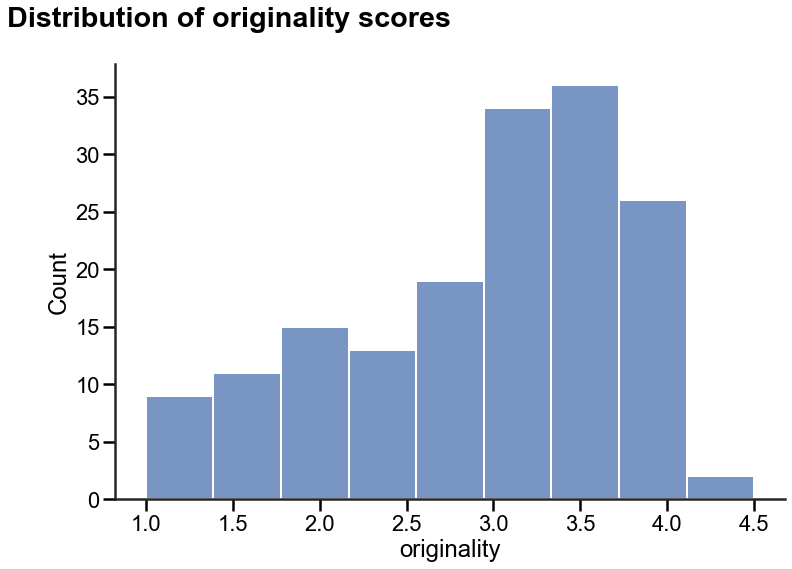

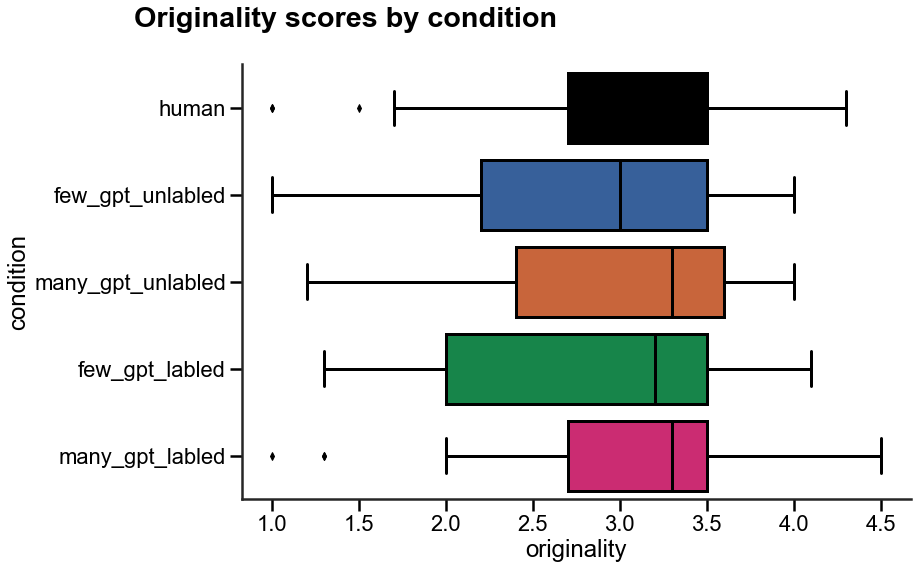

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
def make_aesthetic():
    sns.set(style='white', context='poster')
    themes.theme_few('dark')
    plt.rcParams.update({'font.family':'Arial'})
make_aesthetic()


sns.histplot(df_merged['originality'])
sns.despine()
plt.suptitle("Distribution of originality scores", ha='left', fontweight='bold', x=0)
plt.savefig("orig_dist.png", dpi=300, bbox_inches='tight')
plt.show()

sns.boxplot(data=df_merged, x='originality', y='condition')
sns.despine()
plt.suptitle("Originality scores by condition", ha='left', fontweight='bold', x=0)
plt.savefig("orig_con.png", dpi=300, bbox_inches='tight')
plt.show()

## Tests

In [7]:
import pandas as pd
import pingouin as pg

# Assuming the data is already in a DataFrame called 'df_merged'
# Replace this line with your actual data loading method if necessary
# df_merged = pd.read_csv('your_data.csv')

# Perform pairwise t-tests
pairwise_results = pg.pairwise_ttests(dv='originality', within='condition', subject='prolific_id', data=df_merged, padjust='fdr_bh', effsize='cohen')

# Display the pairwise comparison results
# print(pairwise_results[['A', 'B', 'mean(A)', 'mean(B)', 'diff', 'T', 'p-corr', 'hedges']])
print(pairwise_results[['Contrast', 'A', 'B', 'T', 'dof', 'alternative', 'p-unc', 'p-corr']].to_latex(caption="All pairwise paired t-tests of originality of responses from experimental conditions, with uncorrected p-values and corrected p-values that are adjusted using the FDR adjustment for multiple comparisons. ", float_format="%.2f"))

\begin{table}
\centering
\caption{All pairwise paired t-tests of originality of responses from experimental conditions, with uncorrected p-values and corrected p-values that are adjusted using the FDR adjustment for multiple comparisons. }
\begin{tabular}{llllrrlrr}
\toprule
{} &   Contrast &                 A &                  B &     T &   dof & alternative &  p-unc &  p-corr \\
\midrule
0 &  condition &    few\_gpt\_labled &   few\_gpt\_unlabled &  0.75 & 32.00 &   two-sided &   0.46 &    0.87 \\
1 &  condition &    few\_gpt\_labled &              human & -0.38 & 32.00 &   two-sided &   0.70 &    0.87 \\
2 &  condition &    few\_gpt\_labled &    many\_gpt\_labled & -0.81 & 32.00 &   two-sided &   0.42 &    0.87 \\
3 &  condition &    few\_gpt\_labled &  many\_gpt\_unlabled & -0.28 & 32.00 &   two-sided &   0.78 &    0.87 \\
4 &  condition &  few\_gpt\_unlabled &              human & -1.20 & 32.00 &   two-sided &   0.24 &    0.87 \\
5 &  condition &  few\_gpt\_unlabled &    many\_gp

/Users/jashkina/opt/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/jashkina/opt/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## OLS

In [20]:
import numpy as np
import torch
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertModel
from scipy.spatial.distance import cdist

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

def get_average_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state
    avg_embedding = torch.mean(embeddings, dim=1)
    return avg_embedding

def get_unique_conditions(df):
    return df['condition'].unique()

def compute_embeddings_by_condition(df, conditions):
    embeddings_by_condition = {}
    for condition in conditions:
        responses = df[df['condition'] == condition]['response'].tolist()
        embeddings = [get_average_embedding(response) for response in responses]
        embeddings_by_condition[condition] = torch.stack(embeddings).squeeze().detach().numpy()
    return embeddings_by_condition

def calculate_pairwise_distances(embeddings_by_condition):
    pdists = {}
    for condition, embeddings in embeddings_by_condition.items():
        distance_matrix = cdist(embeddings, embeddings, metric='cosine')
        distance_matrix_no_duplicates = distance_matrix[np.triu_indices(distance_matrix.shape[0], k=1)]
        pdists[condition] = distance_matrix_no_duplicates
    return pdists

def create_long_dataframe(pairwise_distances):
    data = []
    for condition, distances in pairwise_distances.items():
        for distance in distances:
            data.append({'condition': condition, 'distance': distance})
    return pd.DataFrame(data)

conditions = get_unique_conditions(df_merged)
embeddings_by_condition = compute_embeddings_by_condition(df_merged, conditions)
pairwise_distances = calculate_pairwise_distances(embeddings_by_condition)
long_df = create_long_dataframe(pairwise_distances)
long_df['exposure'] = long_df['condition'].apply(lambda x: get_exposure(x))
long_df['transparency'] = long_df['condition'].apply(lambda x: get_transparency(x))


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
long_df['exposure'] = long_df['condition'].apply(lambda x: get_exposure(x))
long_df['transparency'] = long_df['condition'].apply(lambda x: get_transparency(x))

In [25]:
long_df.to_csv("condition_sem_dist.csv")